In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from scipy.linalg import sqrtm

# keras packages
from keras.layers import Input, Dense, Reshape, Flatten, Conv2DTranspose, Conv2D, BatchNormalization, LeakyReLU
from keras.datasets import cifar10
from keras.initializers import RandomNormal
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from skimage.transform import resize

In [0]:
# constants and common functions
inputImageHeight, InputImageWidth = 32, 32
customKernelInitializer = RandomNormal(mean=0, stddev=0.02)

def generateNoise(dimension, samples):
  x = np.random.randn(dimension*samples)
  x =  x.reshape(samples, dimension)
  return x

# scale an array of images to a new size
def scale_images(images, new_shape):
  images_list = list()
  for image in images:
    new_image = resize(image, new_shape, 0)    # resize with nearest neighbor interpolation
    images_list.append(new_image) # store
  return np.asarray(images_list)
 
# calculate frechet inception distance
def calculate_fid(images1, images2):
  model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
  images1 = images1.astype('float32')
  images2 = images2.astype('float32')
  images1 = scale_images(images1, (299,299,3))
  images2 = scale_images(images2, (299,299,3))
  # calculate activations
  act1 = model.predict(images1)
  act2 = model.predict(images2)
  # calculate mean and covariance statistics
  mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
  mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
  # calculate sum squared difference between means
  ssdiff = np.sum((mu1 - mu2)**2.0)
  # calculate sqrt of product between cov
  covmean = sqrtm(sigma1.dot(sigma2))
  # check and correct imaginary numbers from sqrt
  if np.iscomplexobj(covmean):
    covmean = covmean.real
  # calculate score
  fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
  return fid

# https://stackoverflow.com/questions/42281844/what-is-the-mathematics-behind-the-smoothing-parameter-in-tensorboards-scalar
def smooth(scalars, weight) :  # Weight between 0 and 1
    if not scalars: return
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
    return smoothed
  
# https://realpython.com/python-csv/
def plotGraph(filename, smoothingFactor):
  with open(filename) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    graph = []
    for row in csv_reader:
      for column in row:
        graph.append(float(column))
  graph = smooth(graph, smoothingFactor)
  plt.plot(graph)
  return

In [0]:
def DCGANGenerator():
  noise = Input((128,), name='generatorInput')
  # Dense first layer
  firstLayer = Dense(4*4*1024, activation='relu', name='generatorDenseLayer', kernel_initializer=customKernelInitializer)(noise)
  firstLayer = Reshape((4,4,1024))(firstLayer)
  # ConvT Transpose second Layer
  secondLayer = Conv2DTranspose(512, 4, strides=2, padding='same', activation='relu', name='generatorConvTLayer1', kernel_initializer=customKernelInitializer)(firstLayer) # 8x8
  secondLayer = BatchNormalization(name='generatorBatchNormalization1',epsilon=0.00002)(secondLayer)
  # ConvT Transpose third Layer
  thirdLayer = Conv2DTranspose(256, 4, strides=2, padding='same', activation='relu', name='generatorConvTLayer2', kernel_initializer=customKernelInitializer)(secondLayer) # 16x16
  thirdLayer = BatchNormalization(name='generatorBatchNormalization2',epsilon=0.00002)(thirdLayer)
  # ConvT Transpose fourth Layer
  fourthLayer = Conv2DTranspose(128, 4, strides=2, padding='same', activation='relu', name='generatorConvTLayer3', kernel_initializer=customKernelInitializer)(thirdLayer) # 32x32
  fourthLayer = BatchNormalization(name='generatorBatchNormalization3',epsilon=0.00002)(fourthLayer)
  # Conv Transpose Layer
  fifthLayer = Conv2D(3, 4, padding='same', activation='tanh', name='generatorLayer6', kernel_initializer=customKernelInitializer)(fourthLayer) # 32x32
  return Model(noise, fifthLayer)

def DCGANDiscriminator():
  image = Input((inputImageHeight, InputImageWidth, 3))
  # first convolutional layer
  firstLayer = Conv2D(64, 4, strides = 2, padding='same', name='discriminatorLayer1', kernel_initializer=customKernelInitializer)(image) # 16x16
  firstLayer = LeakyReLU(alpha=0.2)(firstLayer)

  # second convolutional layer
  secondLayer = Conv2D(128, 4, strides=2, padding='same', name='discriminatorLayer2', kernel_initializer=customKernelInitializer)(firstLayer) # 8x8
  secondLayer = BatchNormalization(name='discriminatorBatchNormalization1',epsilon=0.00002)(secondLayer)
  secondLayer = LeakyReLU(alpha=0.2)(secondLayer)

  # third convolutional layer
  thirdLayer = Conv2D(256, 4, strides=2, padding='same', name='discriminatorLayer6', kernel_initializer=customKernelInitializer)(secondLayer) # 4x4
  thirdLayer = BatchNormalization(name='discriminatorBatchNormalization2',epsilon=0.00002)(thirdLayer)
  thirdLayer = LeakyReLU(alpha=0.2)(thirdLayer)

  # fourth convolutional layer
  fourthLayer = Conv2D(512, 4, strides = 2, padding='same', name='discriminatorLayer7', kernel_initializer=customKernelInitializer)(thirdLayer) # 2x2
  fourthLayer = BatchNormalization(name='discriminatorBatchNormalization3',epsilon=0.00002)(fourthLayer)
  fourthLayer = LeakyReLU(alpha=0.2)(fourthLayer)

  #fifth convolutional layer
  fifthLayer = Flatten()(fourthLayer)
  fifthLayer = Dense(1, activation='sigmoid', name='discriminatorDenseLayer', kernel_initializer=customKernelInitializer)(fifthLayer)
  return Model(input = image, output=fifthLayer)

In [0]:
generatorDCGan = DCGANGenerator()
discriminatorDCGan = DCGANDiscriminator()
discriminatorDCGan.compile(loss='binary_crossentropy', optimizer=Adam(2e-5, beta_1=0.5), metrics=['accuracy'])

In [0]:
def createDCGan(generatorDCGan, discriminatorDCGan):
  noise = Input((128,))
  image =  Input((inputImageHeight, InputImageWidth, 3))
  generatorImage = generatorDCGan(noise)
  discriminatorDCGan.trainable = False
  discriminatorOutput = discriminatorDCGan(generatorImage)
  return Model(noise,outputs=discriminatorOutput)

In [0]:
generatorDCGan.summary()
discriminatorDCGan.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generatorInput (InputLayer)  (None, 128)               0         
_________________________________________________________________
generatorDenseLayer (Dense)  (None, 16384)             2113536   
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 1024)        0         
_________________________________________________________________
generatorConvTLayer1 (Conv2D (None, 8, 8, 512)         8389120   
_________________________________________________________________
generatorBatchNormalization1 (None, 8, 8, 512)         2048      
_________________________________________________________________
generatorConvTLayer2 (Conv2D (None, 16, 16, 256)       2097408   
_________________________________________________________________
generatorBatchNormalization2 (None, 16, 16, 256)       1024

In [0]:
# load models
discriminatorDCGan = load_model('drive/My Drive/Deep Learning/Project 1/DCGAN/DCGanDisc_model.h5')
generatorDCGan = load_model('drive/My Drive/Deep Learning/Project 1/DCGAN/DCGanGen_model.h5')

combined_model = createDCGan(generatorDCGan, discriminatorDCGan)
combined_model.summary()
combined_model.compile(loss='binary_crossentropy', optimizer=Adam(2e-4, beta_1=0.5), metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128)               0         
_________________________________________________________________
model_1 (Model)              (None, 32, 32, 3)         13134211  
_________________________________________________________________
model_2 (Model)              (None, 1)                 2762177   
Total params: 15,896,388
Trainable params: 13,132,419
Non-trainable params: 2,763,969
_________________________________________________________________


In [0]:
# loading data
(trainingImages, _), (validationImages, _) = cifar10.load_data()

def data_generator(data, batch_size):
  while True:
    currentBatch = data[np.random.randint(data.shape[0], size=batch_size), :]
#     yield currentBatch
    yield currentBatch/127.5 - 1.0

CPU times: user 49.8 ms, sys: 765 µs, total: 50.5 ms
Wall time: 48.7 ms


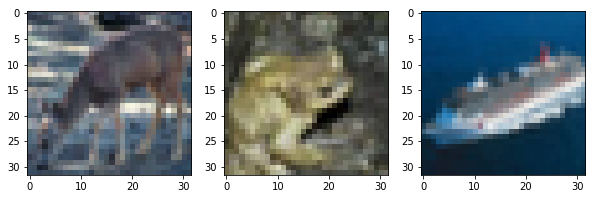

In [0]:
%%time
_, axs = plt.subplots(1, 3, figsize=(10, 10))

for i, d in enumerate(data_generator(trainingImages, 3)):
  images = d*0.5 + 0.5
  axs[0].imshow(images[0])
  axs[1].imshow(images[1])
  axs[2].imshow(images[2])
  if(i == 1):
      break

In [0]:
%%time
# Training DC GAN
batch_size = 128
iteration = 400
epochs = 10
discriminatorLossArray, DCGanGeneratorLoss, discriminatorAccuracy, DCGanGeneratorAccuracy = [], [], [], []

real = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))
noiseInputTest = generateNoise(128, 1)
for epoch in range(epochs):
    for i, d in enumerate(data_generator(trainingImages, batch_size)):
        noiseInput = generateNoise(128, batch_size)
        generatedImage = generatorDCGan.predict(noiseInput)
        
        discriminatorLossReal = discriminatorDCGan.train_on_batch(d, real)
        discriminatorLossFake = discriminatorDCGan.train_on_batch(generatedImage, fake)
        discriminatorLoss = 0.5* np.add(discriminatorLossReal , discriminatorLossFake)
        discriminatorLossArray.append(discriminatorLoss[0])
        discriminatorAccuracy.append(100*discriminatorLoss[1])
        
        noiseInput = generateNoise(128, batch_size)
        DCGan_loss = combined_model.train_on_batch(noiseInput, real)
        DCGanGeneratorLoss.append(DCGan_loss[0])
        DCGanGeneratorAccuracy.append(100*DCGan_loss[1])
        if(i%10 == 0):
            print("Epoch %d/%d   iteration %d/%d  D Acc %3d%%  D Loss: %f  DCGAN Acc: %3d%%  DCGAN Loss: %f" % 
                  (epoch+1, epochs, i, iteration, 100*discriminatorLoss[1], discriminatorLoss[0], 100*DCGan_loss[1], 
                   DCGan_loss[0]))
            
        if(i == iteration-1):
            break
    if (epoch+1) % 2 == 0:
      generatedImage = generatorDCGan.predict(generateNoise(128, 100))
      fid = calculate_fid(generatedImage, validationImages[np.random.randint(validationImages.shape[0], size=100), :]/127.5 - 1)
      print('FID : %.3f' % fid)
      with open('drive/My Drive/Deep Learning/Project 1/DCGAN/discriminatorLossFile.csv', mode='a') as discriminatorLossFile:
        discriminatorLossFile_writer = csv.writer(discriminatorLossFile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        discriminatorLossFile_writer.writerow(discriminatorLossArray)
        discriminatorLossArray = []
      with open('drive/My Drive/Deep Learning/Project 1/DCGAN/DCGanLossFile.csv', mode='a') as DCGanLossFile:
        DCGanLossFile_writer = csv.writer(DCGanLossFile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        DCGanLossFile_writer.writerow(DCGanGeneratorLoss)
        DCGanGeneratorLoss = []
      with open('drive/My Drive/Deep Learning/Project 1/DCGAN/FIDScore.csv', mode='a') as FIDScoreFile:
        FIDScoreFileFile_writer = csv.writer(FIDScoreFile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        FIDScoreFileFile_writer.writerow([fid])
      rpath = 'drive/My Drive/Deep Learning/Project 1/DCGAN/results/'
      generatedImage = generatorDCGan.predict(noiseInputTest)
      plt.imsave(rpath+ '{}_{}_result_1.png'.format(epoch,i), (generatedImage*0.5 + 0.5).reshape(32, 32, 3))
      plt.close()
      generatorDCGan.save('drive/My Drive/Deep Learning/Project 1/DCGAN/DCGanGen_model.h5')
      discriminatorDCGan.save('drive/My Drive/Deep Learning/Project 1/DCGAN/DCGanDisc_model.h5')

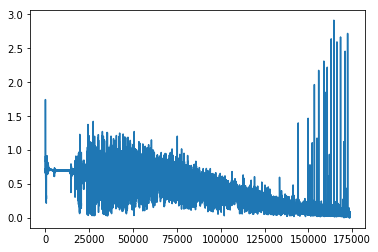

In [0]:
plotGraph('discriminatorLossFile.csv', 0.6)

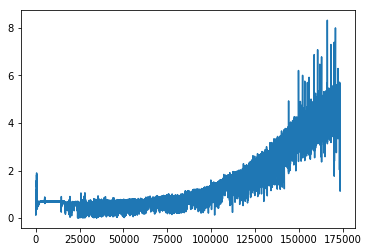

In [0]:
plotGraph('DCGanLossFile.csv', 0.6)

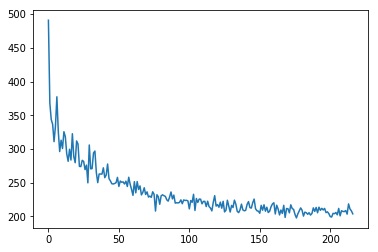

In [0]:
plotGraph('FIDScore.csv', 0)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


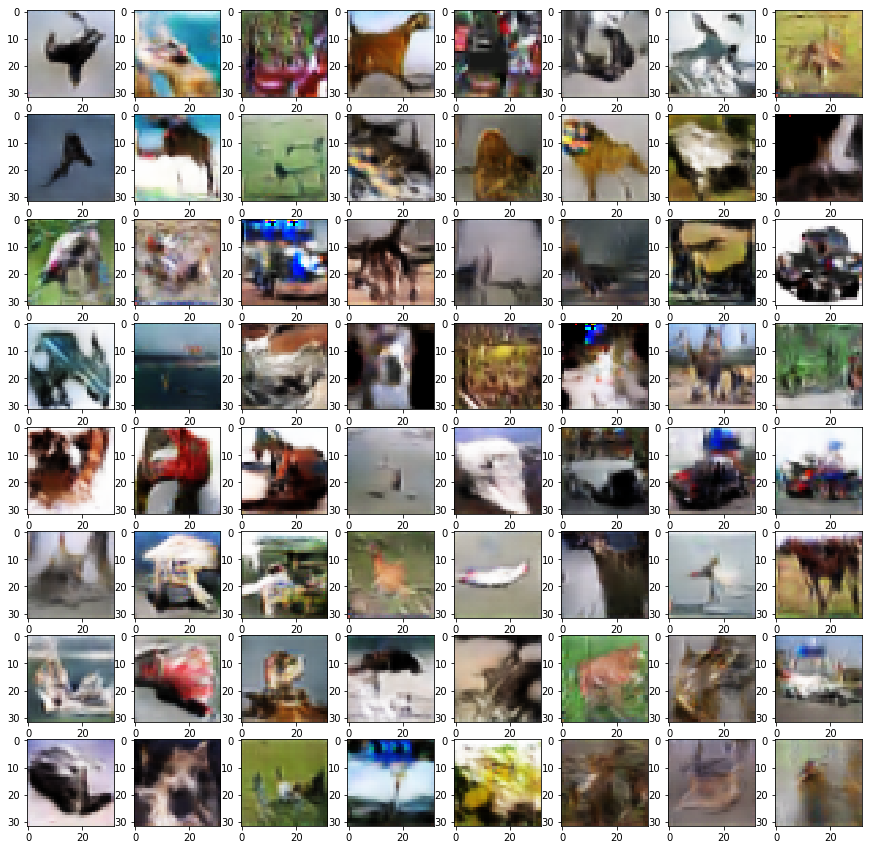

In [0]:
# Generate 8x8 grid
generatorDCGan = load_model('DCGanGen_model.h5')

_, axs = plt.subplots(8, 8, figsize=(15, 15))

noiseInputTest = generateNoise(128, 64)
generatedImage = generatorDCGan.predict(noiseInputTest)
generatedImage = (generatedImage*0.5 + 0.5).reshape(64,32, 32, 3)
for i in range(8):
  for j in range(8):
    axs[i][j].imshow(generatedImage[i*8+j])